In [13]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch

In [2]:
data_path = '../Datas/uschad_activity_dataset.h5'

In [10]:
with h5py.File(data_path, 'r') as f_r:
    data_genbylabel = f_r['data_genbylabel'][:]
    test_sample = data_genbylabel[100,:,1]
    print(data_genbylabel.shape)
    
    jumping_data = f_r['datas']['jumping'][:]
    print(jumping_data.shape)

(28102, 100, 6)
(107100, 6)


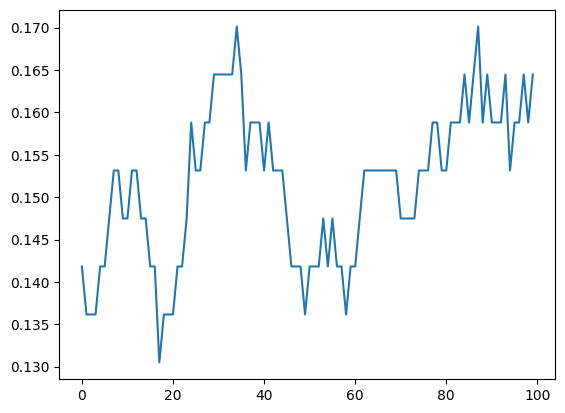

In [9]:
plt.plot(test_sample)

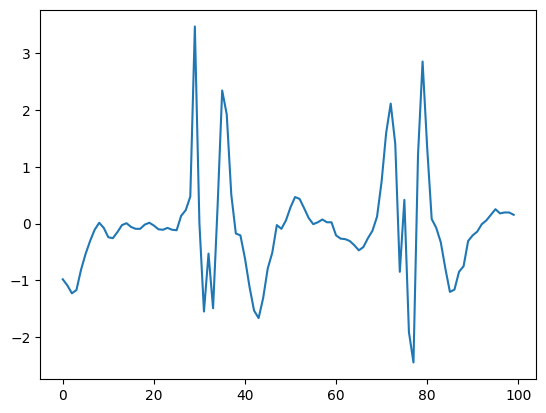

In [12]:
jumping_sample = jumping_data[100:200,1]
plt.plot(jumping_sample)

In [52]:
def norm_and_main_freq(x, k):
    print('check input shape', x.shape)
    # Apply FFT to get the frequency domain representation
    z = torch.fft.rfft(x, dim=2)
    print('z shape', z.shape)
    
    # Find the top k largest magnitude frequency indices
    ks = torch.topk(z.abs(), k, dim=2)
    top_k_indices = ks.indices
    print('check top k indices', top_k_indices.shape)
    
    # Create a mask for the top k frequencies
    mask = torch.zeros_like(z)
    mask.scatter_(2, top_k_indices, 1)  # Set top k frequency indices to 1
    
    # Apply mask to get the top k frequency components
    z_m = z * mask  # z_m contains only the top k frequency components
    
    # Get the remaining frequencies (by zeroing out the top k components)
    z_r = z * (1 - mask)  # z_r contains the remaining lower magnitude frequencies
    
    # Apply inverse FFT to bring the signals back to time domain
    x_m = torch.fft.irfft(z_m, dim=2).real  # Main frequency components
    x_r = torch.fft.irfft(z_r, dim=2).real  # Remaining part (without top k frequencies)
    
    # Return both components
    return x_r, x_m


In [53]:
input_tensor = torch.tensor(data_genbylabel[100:124,:,:]).float().permute(0, 2, 1)
x_r, x_m = norm_and_main_freq(input_tensor, 5)
print(x_r.shape, x_m.shape)

check input shape torch.Size([24, 6, 100])
z shape torch.Size([24, 6, 51])
check top k indices torch.Size([24, 6, 5])
torch.Size([24, 6, 100]) torch.Size([24, 6, 100])


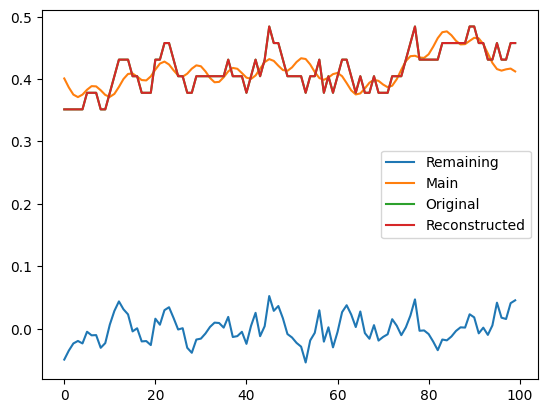

In [54]:
plt.plot(x_r[19,2,:], label='Remaining')
plt.plot(x_m[19,2,:], label='Main')
plt.plot(input_tensor[19,2,:], label='Original')
plt.plot(x_r[19,2,:] + x_m[19,2,:], label='Reconstructed')
plt.legend()
plt.show()

In [57]:
jumping_sample = jumping_data[1000:1100, :]
x_r, x_m = norm_and_main_freq(torch.tensor(jumping_sample).unsqueeze(0).float().permute(0,2,1), 5)
print(x_r.shape, x_m.shape)

check input shape torch.Size([1, 6, 100])
z shape torch.Size([1, 6, 51])
check top k indices torch.Size([1, 6, 5])
torch.Size([1, 6, 100]) torch.Size([1, 6, 100])


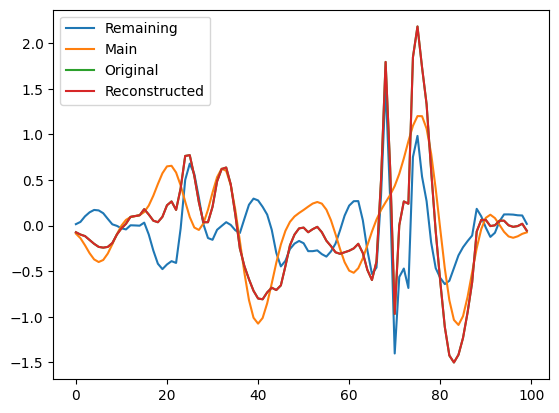

In [59]:
plt.plot(x_r[0,1,:], label='Remaining')
plt.plot(x_m[0,1,:], label='Main')
plt.plot(jumping_sample[:,1], label='Original')
plt.plot(x_r[0,1,:] + x_m[0,1,:], label='Reconstructed')
plt.legend()
plt.show()